In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import savemat
import os


In [7]:
class OFDM_TX: 
    def __init__(self,ifft_size,cp_length,num_symbols,mod_order,num_active):
        self.ifft_size = ifft_size
        self.cp_length = cp_length
        self.num_symbols = num_symbols
        self.mod_order = mod_order
        self.num_active = num_active 

    def OFDM_Tx(self):
        Ld = self.ifft_size
        Ls = Ld + self.cp_length 
        dc_index = self.ifft_size // 2 
        half = self.num_active // 2
        active_subcarriers = list(range(dc_index - half, dc_index)) + \
                            list(range(dc_index + 1, dc_index + half + 1))
        return dc_index, active_subcarriers

    def generate_mqam_symbols(self):
        bits_per_symbol = int(np.log2(self.mod_order))
        total_bits = self.num_active * self.num_symbols * bits_per_symbol
        bits = np.random.randint(0,2,total_bits) 
        symbol_bin = bits.reshape(-1,bits_per_symbol) 
        bits_per_axis = bits_per_symbol // 2 
        M_axis = int(np.sqrt(self.mod_order)) 
        bits_I = symbol_bin[:, :bits_per_axis] 
        bits_Q = symbol_bin[:, bits_per_axis:] 
        def bin2dec(arr): 
            return arr.dot(1 << np.arange(arr.shape[-1]-1,-1,-1))
        I_indices = bin2dec(bits_I)
        Q_indices = bin2dec(bits_Q) 
        I_vals = 2*I_indices - (M_axis - 1)
        Q_vals = 2*Q_indices - (M_axis - 1)
        qam_data = I_vals + 1j*Q_vals 
        qam_data /= np.sqrt(np.mean(np.abs(qam_data)**2))

        return qam_data, bits 

    def generate_ofdm_signal(self, qam_data, active_subcarriers, dc_index):
        self.num_active = len(active_subcarriers)
        symbol_matrix = np.zeros((self.num_symbols, self.ifft_size), dtype=complex)
        ofdm_signal = []

        for i in range(self.num_symbols):
            idx_start = i * self.num_active
            idx_end = (i + 1) * self.num_active
            this_symbol = qam_data[idx_start:idx_end]
            freq_data = np.zeros(self.ifft_size, dtype=complex)
            freq_data[active_subcarriers] = this_symbol
            freq_data[dc_index] = 0  # Null DC
            time_data = np.fft.ifft(freq_data) * np.sqrt(self.ifft_size)
            symbol_matrix[i, :] = freq_data
            cp = time_data[-self.cp_length:]
            ofdm_symbol = np.concatenate((cp, time_data))
            ofdm_signal.append(ofdm_symbol)

        ofdm_signal = np.concatenate(ofdm_signal)
        ofdm_signal /= np.sqrt(np.mean(np.abs(ofdm_signal) ** 2))

        return ofdm_signal, symbol_matrix

    def add_noise_and_pad(self,ofdm_signal, noise_snr_db, left_pad, right_pad, save_path='OFDM_Rx_Signal.mat'):
        signal_power = np.mean(np.abs(ofdm_signal)**2)
        noise_power = signal_power / (10**(noise_snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        inband_noise = noise_std * (np.random.randn(len(ofdm_signal)) + 1j * np.random.randn(len(ofdm_signal)))
        ofdm_signal_noisy = ofdm_signal + inband_noise
        noise_before = noise_std * (np.random.randn(left_pad) + 1j * np.random.randn(left_pad))
        noise_after  = noise_std * (np.random.randn(right_pad) + 1j * np.random.randn(right_pad))
        final_signal = np.concatenate([noise_before, ofdm_signal_noisy, noise_after])
        savemat(save_path, {'final_signal': final_signal})

        return final_signal

    def ofdm_demodulate(self,ofdm_signal_noisy, ifft_size, cp_length):
        Ld = ifft_size
        Ls = Ld + cp_length
        num_symbols_actual = len(ofdm_signal_noisy) // Ls
        X_matrix = ofdm_signal_noisy[:num_symbols_actual * Ls].reshape((num_symbols_actual, Ls))
        X_no_cp = X_matrix[:, cp_length:] 
        X_fft = np.fft.fft(X_no_cp, axis=1)
        power_matrix = np.abs(X_fft) ** 2  
        full_power = np.zeros((num_symbols_actual, ifft_size))
        full_power[:, :Ld] = power_matrix

        return full_power, X_fft, power_matrix

    def plot_subcarrier_power_improved(self,power_matrix, ifft_size, num_symbols_actual):
        power_db = 10 * np.log10(power_matrix + 1e-12)  # avoid log(0)
        plt.figure(figsize=(12, 5))
        extent = [0, num_symbols_actual, 0, ifft_size]
        im = plt.imshow(
            power_db.T,
            aspect='auto',
            extent=extent,
            origin='lower',
            cmap='jet',
            vmin=np.max(power_db) - 40,
            vmax=np.max(power_db)
        )
        plt.title('Subcarrier Power Spectrum (dB)', fontsize=14)
        plt.xlabel('OFDM Symbol Index', fontsize=12)
        plt.ylabel('Subcarrier Index', fontsize=12)
        plt.colorbar(im, label='Power (dB)')
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    
    def plot_autocorrelation(self,signal, max_lag=None):
        N = len(signal)
        if max_lag is None:
            max_lag = N // 2
        corr = np.correlate(signal, signal, mode='full') 
        lags = np.arange(-N + 1, N)
        corr = corr / np.max(np.abs(corr)) 
        positive_lags = lags >= 0
        lags_positive = lags[positive_lags][:max_lag]
        Rxx_positive = corr[positive_lags][:max_lag]
        plt.figure(figsize=(10, 4))
        plt.plot(lags_positive, np.abs(Rxx_positive))
        plt.title('Autocorrelation of the Received Signal')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation Coefficient')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_psd_strictly_symmetric(self,power_matrix, ifft_size, fs=1.0):
        avg_power = np.mean(power_matrix, axis=0)
        psd_shifted = np.fft.fftshift(avg_power) / (fs / ifft_size)
        psd_db = 10 * np.log10(psd_shifted + 1e-12)
        if ifft_size % 2 == 0:
            freq_axis = np.linspace(-fs/2, fs/2, ifft_size, endpoint=False)
        else:
            freq_axis = np.linspace(-fs/2, fs/2, ifft_size)
        plt.figure(figsize=(10, 4))
        plt.plot(freq_axis, psd_db, linewidth=1.2)
        plt.title('Power Spectral Density (dB/Hz)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_constellation(self,X_fft, active_subcarriers):
        rx_constellation = X_fft[:, active_subcarriers] 
        rx_symbols_flat = rx_constellation.flatten()
        avg_power = np.mean(np.abs(rx_symbols_flat)**2)
        scale = 2 * np.sqrt(avg_power)
        plt.figure(figsize=(6, 6))
        plt.scatter(rx_symbols_flat.real, rx_symbols_flat.imag, s=10, c='blue', alpha=0.6)
        plt.title('QPSK Constellation after OFDM Demodulation')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.xlim([-scale, scale])
        plt.ylim([-scale, scale])
        plt.tight_layout()
        plt.show()


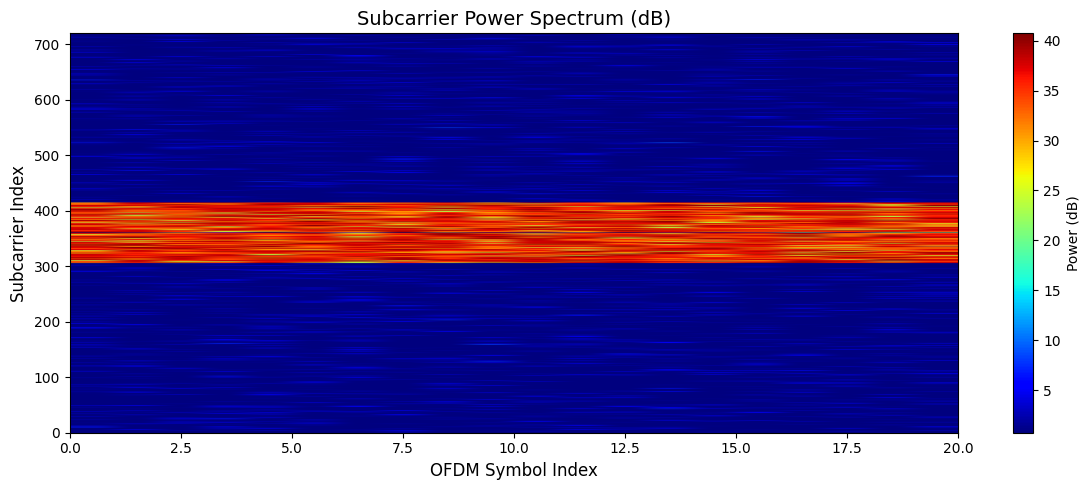

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


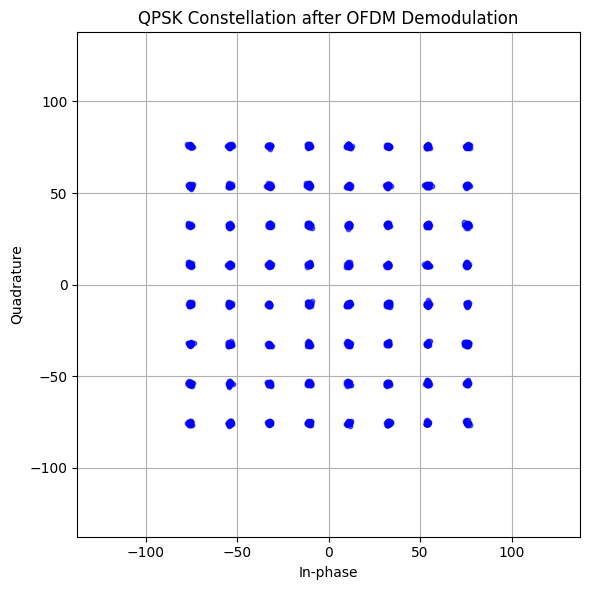

In [11]:
ifft_size = 720
cp_length = 80
num_symbols = 20
mod_order = 64
num_active = 109
snr_db = 30
left_pad = 200
right_pad = 200

# Step 1: Instantiate the class
ofdm = OFDM_TX(ifft_size, cp_length, num_symbols, mod_order, num_active)
# Step 2: Get active subcarriers and DC index
dc_index, active_subcarriers = ofdm.OFDM_Tx()
# Step 3: Generate QAM symbols and bits
qam_data, tx_bits = ofdm.generate_mqam_symbols()
# Step 4: Generate OFDM signal
ofdm_signal, symbol_matrix = ofdm.generate_ofdm_signal(qam_data, active_subcarriers, dc_index)
# Step 5: Add noise and padding
rx_signal = ofdm.add_noise_and_pad(ofdm_signal, snr_db, left_pad, right_pad)
# Step 6: Demodulate OFDM signal (remove padding first)
rx_no_pad = rx_signal[left_pad: -right_pad]
power_matrix, X_fft, _ = ofdm.ofdm_demodulate(rx_no_pad, ifft_size, cp_length)

# Step 7: Plot subcarrier power (optional)
ofdm.plot_subcarrier_power_improved(power_matrix, ifft_size, num_symbols)
# Step 8: Plot constellation (optional)
ofdm.plot_constellation(X_fft, active_subcarriers)
